# Benchmarking Exact Diagonalization for $\mathbb{Z}2$ models

We assess the computational time of the sparse algorithm. In particular, we focus on the Exact Diagonalization algorithm for a Z2 spin lattice model. The theory is a pure gauge theory.

To use this notebook do:
```pip install qs-mps```


In [5]:
from qs_mps.applications.Z2.exact_hamiltonian import H_Z2_gauss
import time
import numpy as np

## Vary the spin lattice size $l$ x $L$

We will repeat the time estimation for $i=20$ times to create a reliable statistic. In that way, the fitting function will be more stable to fluctuations and be more precise in predicting times we have not computed.

In [165]:
ls = [2,3,4]
model = "Z2_dual"
h = 1
path = "/Users/fradm98/Library/CloudStorage/GoogleDrive-fra.di.marcantonio@gmail.com/My Drive/projects/1_Z2/results/exact/time_data"

time_tot = []
for i in range(20):
    time_tot_i = []
    for l in ls:
        for L in range(l,ls[-1]+1):
            if (l == 4 and L == 5) or (l == 5 and L == 5):
                break
            else:
                dof_direct = (2*l*L - l - L)
                # print(f"computing guess for l={l}, L={L}")
                # time_st = time.perf_counter()
                c = (1/np.sqrt(2))**dof_direct
                v0 = [c]*(2**dof_direct)
                v0 = np.array(v0, dtype=complex)
                # time_end = abs(time.perf_counter() - time_st)
                # print(f"Time of computation: {time_end} sec")
                # print("==============================")
                print(f"start ED for l={l}, L={L}")
                time_st = time.perf_counter()
                lattice = H_Z2_gauss(l=l, L=L, model=model, lamb=h)
                lattice.diagonalize(v0=v0, save=False)

                time_end = abs(time.perf_counter() - time_st)
                print(f"Time of computation: {time_end} sec")
                print("==============================")
                print("==============================\n")
                time_tot_i.append(time_end)
    time_tot.append(time_tot_i)

start ED for l=2, L=2
Time of computation: 0.012896886037196964 sec

start ED for l=2, L=3
Time of computation: 0.015657712996471673 sec

start ED for l=2, L=4
Time of computation: 0.0291173430159688 sec

start ED for l=3, L=3
Time of computation: 0.11274737503845245 sec

start ED for l=3, L=4
Time of computation: 7.51271793799242 sec

start ED for l=4, L=4
Time of computation: 1470.0660346020013 sec

start ED for l=2, L=2
Time of computation: 0.008796632988378406 sec

start ED for l=2, L=3
Time of computation: 0.013815657992381603 sec

start ED for l=2, L=4
Time of computation: 0.024405985022895038 sec

start ED for l=3, L=3
Time of computation: 0.07276749901939183 sec

start ED for l=3, L=4
Time of computation: 7.5062652450287715 sec

start ED for l=4, L=4
Time of computation: 1467.834604788979 sec

start ED for l=2, L=2
Time of computation: 0.00844936299836263 sec

start ED for l=2, L=3
Time of computation: 0.014047759992536157 sec

start ED for l=2, L=4
Time of computation: 0.02515

Now we have obtained a matrix in which each row has the chosen lattices computation times. We can find an average one and the relative standard deviation

In [166]:
time_tot = np.array(time_tot)
time_av = np.mean(time_tot, axis=0)
time_std_devs = np.std(time_tot, axis=0)
np.savetxt(f"{path}/times_ed_l_[{ls[0]},{ls[0]}]_L_{ls[-1]},{ls[-1]}", time_av)

We plot the results with the relative error bars. The computations we perform really depends on the number of degrees of freedom of the lattice. The formula is
$$ dof = 2* l * L - l - L $$
where $(l-1)$ is the number of **ladders**, and $L$ is the number of **rungs** in each ladder.

In [167]:
# degrees of freedom and lattices explored
dofs = [(2*l*L-l-L) for l in ls for L in range(l,ls[-1]+1)]
lattice_dims = [f"{l-1}x{L-1}" for l in ls for L in range(l,ls[-1]+1)]

# to avoid long computations we excluded some lattice dimensions (the most expensive at the end of the lists)
while len(time_av) != len(dofs):
    dofs.pop()
    lattice_dims.pop()
print(time_av)
print(time_std_devs)
print(dofs)
print(lattice_dims)

# # sort the degrees of freedom, computational times. and lattice dimensions
# a = lattice_dims[4]
# lattice_dims[4] = lattice_dims[3]
# lattice_dims[3] = a
# time_tot = np.array(time_tot)
# dofs = np.array(dofs)
# dofs_sorted = np.sort(dofs)
# time_sorted = np.sort(time_tot)

[8.84535519e-03 1.39537688e-02 2.59160165e-02 9.83332828e-02
 7.52795088e+00 1.47522909e+03]
[9.56902412e-04 5.99069349e-04 2.95147538e-03 1.50367070e-02
 1.08812215e-01 1.63404188e+01]
[4, 7, 10, 12, 17, 24]
['1x1', '1x2', '1x3', '2x2', '2x3', '3x3']


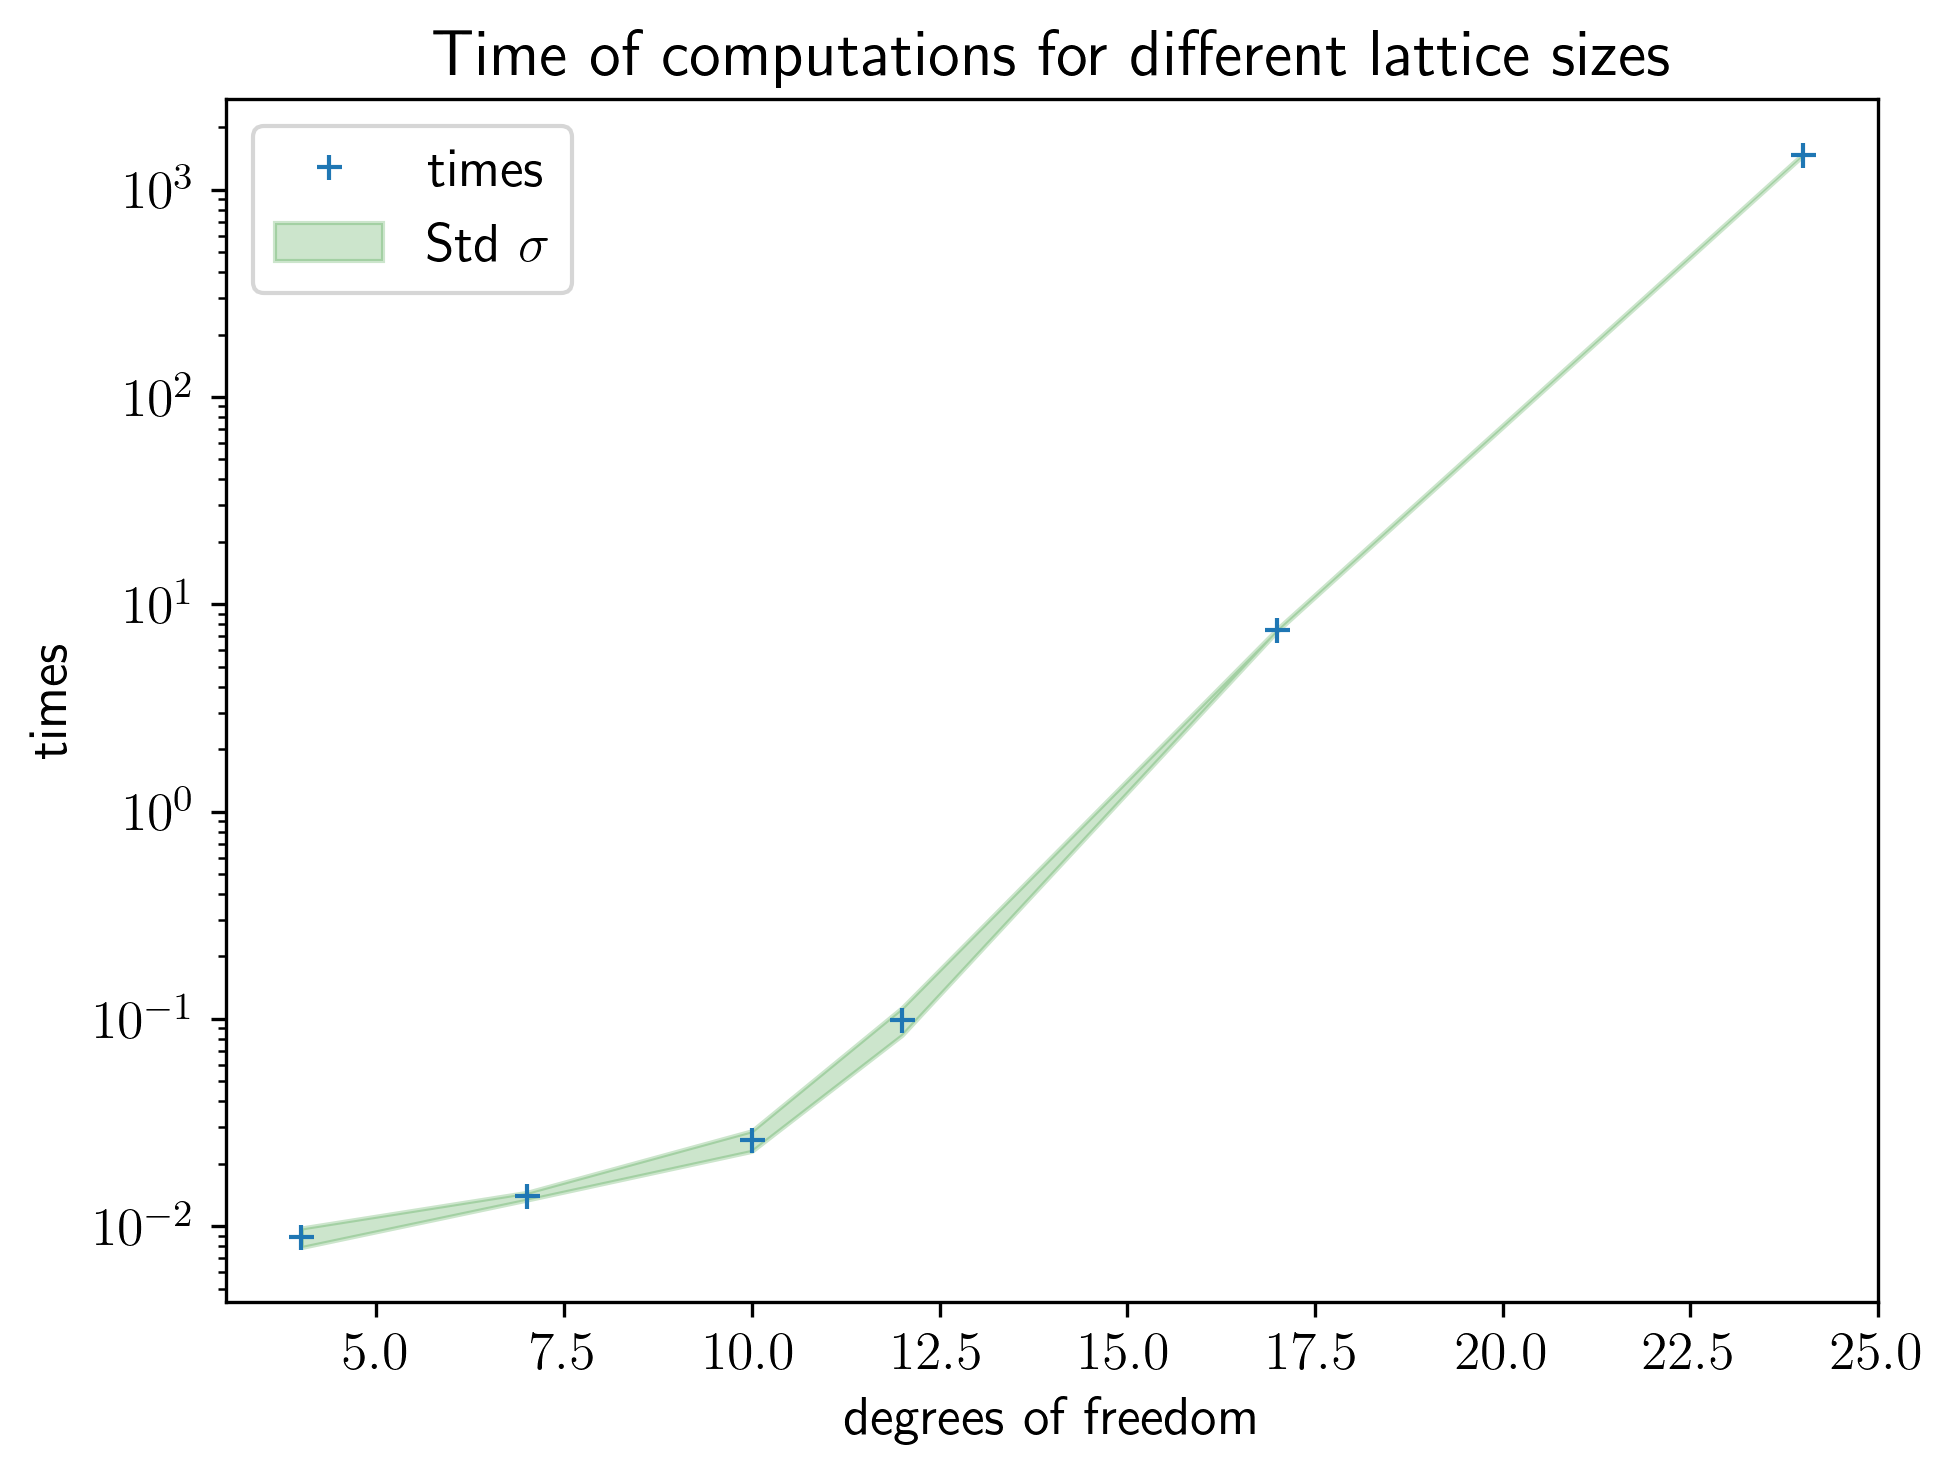

In [168]:
# load time
time_av = np.loadtxt(f"{path}/times_ed_l_[{ls[0]},{ls[0]}]_L_{ls[-1]},{ls[-1]}")

# import function
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams["text.usetex"] = True # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

plt.title("Time of computations for different lattice sizes")
plt.plot(dofs, time_av, '+', label="times")
plt.fill_between(dofs, time_av-time_std_devs, time_av+time_std_devs, color='green', alpha=0.2, label='Std $\sigma$')
plt.yscale('log')
plt.xlabel("degrees of freedom")
plt.ylabel("times")
plt.legend()
plt.show()

Now you can plot the results and check which fit works better. First, we need to define the functions for fitting:

In [4]:
def exponential_function(x, a, b, c):
    """
    Exponential function: a * exp(b * x) + c
    """
    return a * np.exp(x * b) + c

def poly_function(x, a, b, c):
    """
    Poly function: a * x ** b + c
    """
    return a * x ** b + c

def linear_function(x, a, b):
    """
    Linear function: a * x + b
    """
    return a * x + b


def fit(x_data, y_data, ftype, guess=None):
    """
    Fit function to given data.
    
    Parameters:
    - x_data: Input data (independent variable)
    - y_data: Output data (dependent variable)
    - ftype: type of function we fit
    
    Returns:
    - Coefficients of the fitted function
    """
    # Use curve_fit to fit the data to the exponential function
    if ftype == "exp":
        params, covariance = curve_fit(exponential_function, x_data, y_data, guess)
    if ftype == "poly":
        params, covariance = curve_fit(poly_function, x_data, y_data, guess)
    if ftype == "lin":
        params, covariance = curve_fit(linear_function, x_data, y_data, guess)
    
    # Extract the coefficients
    err = np.sqrt(np.diag(covariance))
    return params, err

Now we fit and plot

[4, 7, 10, 12, 17, 24] [8.84535519e-03 1.39537688e-02 2.59160165e-02 9.83332828e-02
 7.52795088e+00 1.47522909e+03]
[16, 128, 1024, 4096, 131072, 16777216]


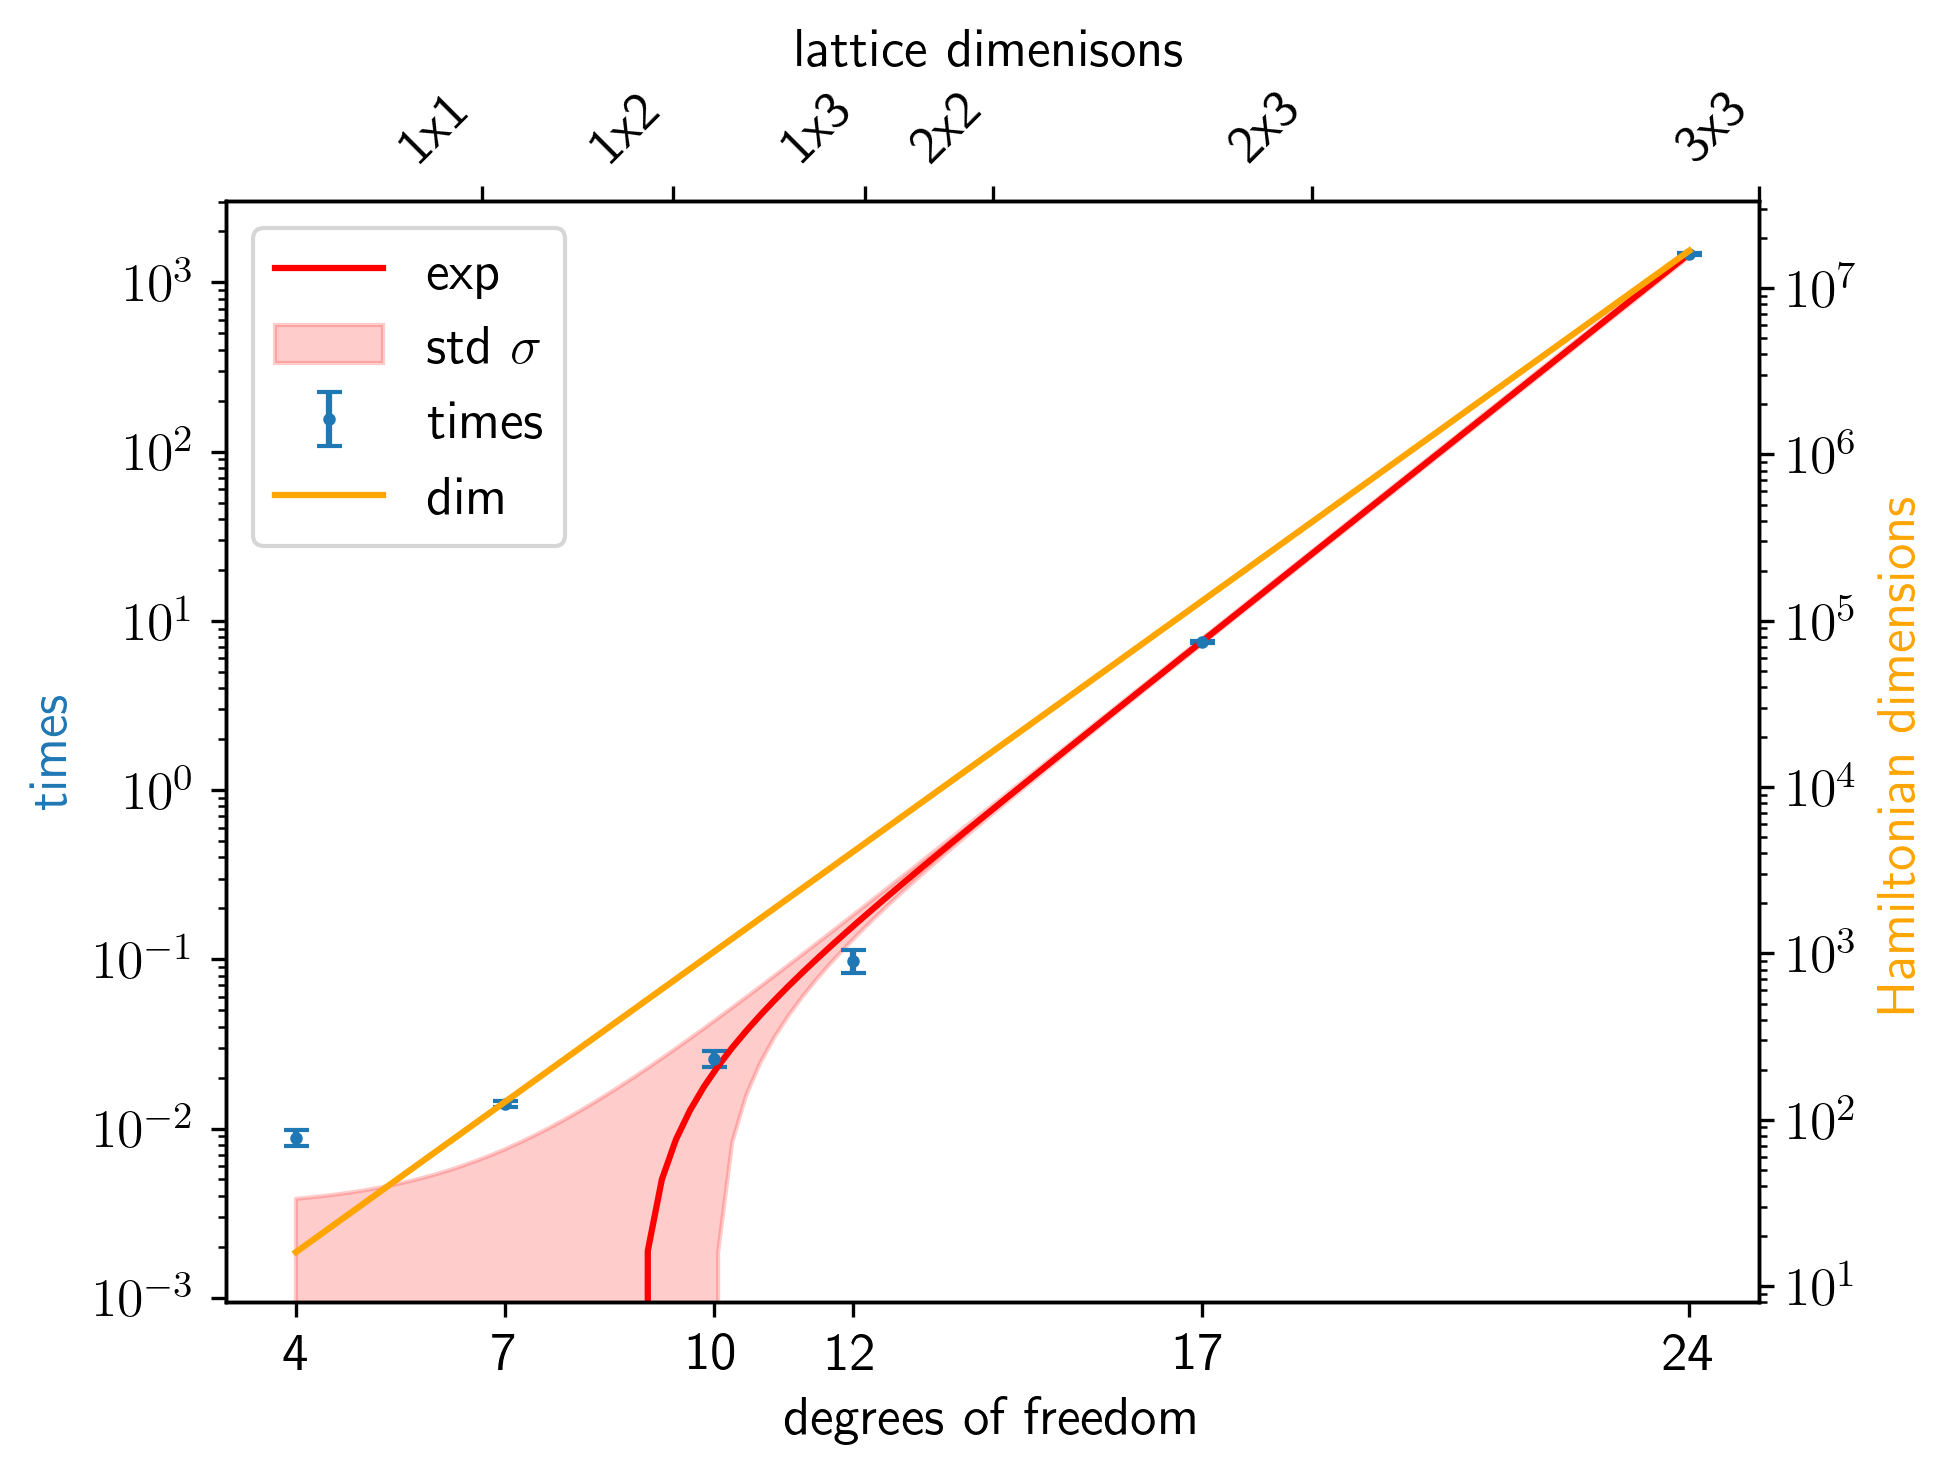

In [170]:
x_data = dofs
y_data = time_av
print(x_data, y_data)

H_dims = [2**(dof) for dof in dofs]
print(H_dims)

x_fit = np.linspace(dofs[0],dofs[-1],100, endpoint=True)
# Fit the data to the exponential function
params_exp, err_exp = fit(x_data, y_data, 'exp', [0.01,0.5,-0.01])
a = params_exp[0]
b = params_exp[1]
c = params_exp[2]
a_std = err_exp[0]
b_std = err_exp[1]
c_std = err_exp[2]

fig, ax1 = plt.subplots()
ax1.errorbar(dofs, y_data,  yerr=time_std_devs, capsize=3, fmt='o', markersize=2, label="times")
ax1.plot(x_fit, exponential_function(x_fit, a=a, b=b, c=c), color='r', label="exp")
ax1.fill_between(x_fit, exponential_function(x_fit, a=a-a_std, b=b-b_std, c=c-c_std), exponential_function(x_fit, a=a+a_std, b=b+b_std, c=c+c_std), alpha=0.2, color='r', label="std $\sigma$")
ax1.set_xlabel("degrees of freedom")
ax1.set_ylabel("times", color="C0")
ax1.set_yscale("log")
ax1.set_xticks(dofs)
ax1.set_xticklabels(dofs)


ax2 = ax1.twinx()
ax2.plot(dofs, H_dims, color='orange', label="dim")
ax2.set_ylabel("Hamiltonian dimensions", color='orange')
ax2.set_yscale("log")

ax3 = ax1.twiny()
ax3.set_xlabel("lattice dimenisons")
ax3.set_xticks(x_data)
ax3.set_xticklabels(lattice_dims, rotation=45, ha="right")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

In [2]:
def estimation_ED_time(l: int, L:int, precision: int=2):
    dof = 2*l*L - l - L
    # the most accurate parameters of the exponential functions
    a = 2.0551463648246553e-05
    b = 0.7537149361332958
    c = -0.016958974393130422
    a_std = 4.2489645545391294e-07
    b_std = 0.000861183081504832
    c_std = 0.020372670605654543
    t = exponential_function(dof, a=a, b=b, c=c)
    t_plus = exponential_function(dof, a=a+a_std, b=b+b_std, c=c+c_std)
    t_minus = exponential_function(dof, a=a-a_std, b=b-b_std, c=c-c_std)
    t_pm = np.mean(np.array([np.abs(t_plus-t),np.abs(t-t_minus)]))

    if t > 0 and t < 60:
        u = "sec(s)"
    elif t > 60 and t < 3600:
        t = t/60
        t_pm = t_pm/60
        u = "min(s)"
    elif t > 3600 and t < 3600*24:
        t = t/3600
        t_pm = t_pm/3600
        u = "hour(s)"
    elif t > 3600*24:
        t = t/(3600*24)
        t_pm = t_pm/(3600*24)
        u = "day(s)"
    
    print(f"The estimated time for a lattice {l-1}x{L-1} is: ({t:.{precision}f} +\- {t_pm:.{precision}f}) {u}")
    return t

In [6]:
time_est = estimation_ED_time(l=3,L=4)

The estimated time for a lattice 2x3 is: (7.53 +\- 0.29) sec(s)
